# Grocery Purchase Analysis & Recommendations

This notebook demonstrates three complementary pipelines for exploring and recommending products based on user purchase histories:

1. **User Clustering via MinHash LSH & GraphFrames**  
   - Load transactional data (`official_df.csv`), extract user–item sets  
   - Build binary “features” vectors with `HashingTF`  
   - Approximate user–user Jaccard similarities with `MinHashLSH`  
   - Filter similar user pairs, construct a GraphFrame, and find connected components  
   - Visualize a sampled user‐similarity graph with NetworkX

2. **Bipartite User–Product Graph Construction & Visualization**  
   - Create unified vertices (prefixing IDs: `u_<user>`, `p_<product>`)  
   - Build edges carrying the `reordered` flag as weight  
   - Visualize any two users’ product sets (shared vs. unique) in a directed graph

3. **Neighborhood-Based Collaborative Filtering**  
   - Reuse MinHashLSH user similarities to define “neighbors” (distance below a threshold)  
   - Generate candidate recommendations: items purchased by neighbors but not by the target user  
   - Score candidates by neighbor vote counts and pick the top‐N per user  
   - Inspect neighbor counts and sample recommendations for a handful of users

---

**Requirements & Setup**  
- Python packages: `pyspark` (with `graphframes`), `networkx`, `matplotlib`, `pandas`  
- A working Spark cluster or local installation with the GraphFrames JAR  
- Input file: `official_df.csv` containing at least  
  - `user_id`, `product_id`, `product_name`, `reordered`  

Run each code cell in order to reproduce data loading, clustering, graph construction, visualization, and neighborhood-CF recommendations.  


In [1]:
!pip install graphframes

In [3]:
# 1. Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
from pyspark.ml.feature import HashingTF, MinHashLSH
from graphframes import GraphFrame

# 2. Spark session (with GraphFrames)
spark = (
    SparkSession
    .builder
    .appName("UserClusteringLSH")
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12")
    .getOrCreate()
)
# GraphFrames needs a checkpoint dir
spark.sparkContext.setCheckpointDir("/tmp/graphframes_checkpoint")

# 3. Load only the columns you care about
df = (
    spark.read
         .csv("official_df.csv", header=True, inferSchema=True)
         .select("user_id", "product_id")
)

# 4. Rename and aggregate
df = df.withColumnRenamed("product_id", "item") \
       .groupBy("user_id") \
       .agg(collect_list("item").alias("items"))

# 5. Vectorize with HashingTF (binary membership)
hashingTF = HashingTF(inputCol="items", outputCol="features",
                      numFeatures=10_000, binary=True)
df = hashingTF.transform(df)

# 6. MinHash LSH model
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=3)
mh_model = mh.fit(df)
df = mh_model.transform(df)

# 7. Approximate similarity join (Jaccard similarity > 0.8)
#    distance = 1 − similarity
similar_pairs = mh_model.approxSimilarityJoin(df, df, 0.9,
                                              distCol="JaccardDistance")

# 8. Filter out self‐matches and show results
non_self = similar_pairs.filter("datasetA.user_id != datasetB.user_id")
non_self.select(
    "datasetA.user_id",
    "datasetB.user_id",
    "JaccardDistance"
).show(truncate=False)

# 9. Build GraphFrame and find connected components
vertices = df.select("user_id").distinct().withColumnRenamed("user_id","id")
edges    = non_self.selectExpr(
               "datasetA.user_id AS src",
               "datasetB.user_id AS dst",
               "JaccardDistance"
           )

g = GraphFrame(vertices, edges)
clusters = g.connectedComponents()
clusters.select("id","component").show(truncate=False)


+-------+-------+------------------+
|user_id|user_id|JaccardDistance   |
+-------+-------+------------------+
|101    |1404   |0.8888888888888888|
|1955   |807    |0.8888888888888888|
|1623   |1268   |0.8888888888888888|
|2063   |280    |0.8823529411764706|
|582    |283    |0.8571428571428572|
|582    |509    |0.8666666666666667|
|582    |355    |0.8333333333333334|
|509    |582    |0.8666666666666667|
|283    |582    |0.8571428571428572|
|961    |1873   |0.8461538461538461|
|1990   |285    |0.8947368421052632|
|444    |1013   |0.8780487804878049|
|585    |249    |0.875             |
|2179   |582    |0.8               |
|249    |409    |0.8666666666666667|
|807    |249    |0.75              |
|1873   |961    |0.8461538461538461|
|582    |2179   |0.8               |
|1013   |444    |0.8780487804878049|
|786    |573    |0.8666666666666667|
+-------+-------+------------------+
only showing top 20 rows



/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+----+---------+
|id  |component|
+----+---------+
|1990|56       |
|1699|56       |
|451 |451      |
|2156|2156     |
|961 |56       |
|857 |857      |
|1417|1417     |
|155 |155      |
|1344|56       |
|1404|101      |
|1378|1378     |
|101 |101      |
|756 |756      |
|1496|1281     |
|762 |762      |
|596 |596      |
|787 |787      |
|1307|1307     |
|1480|1480     |
|27  |27       |
+----+---------+
only showing top 20 rows



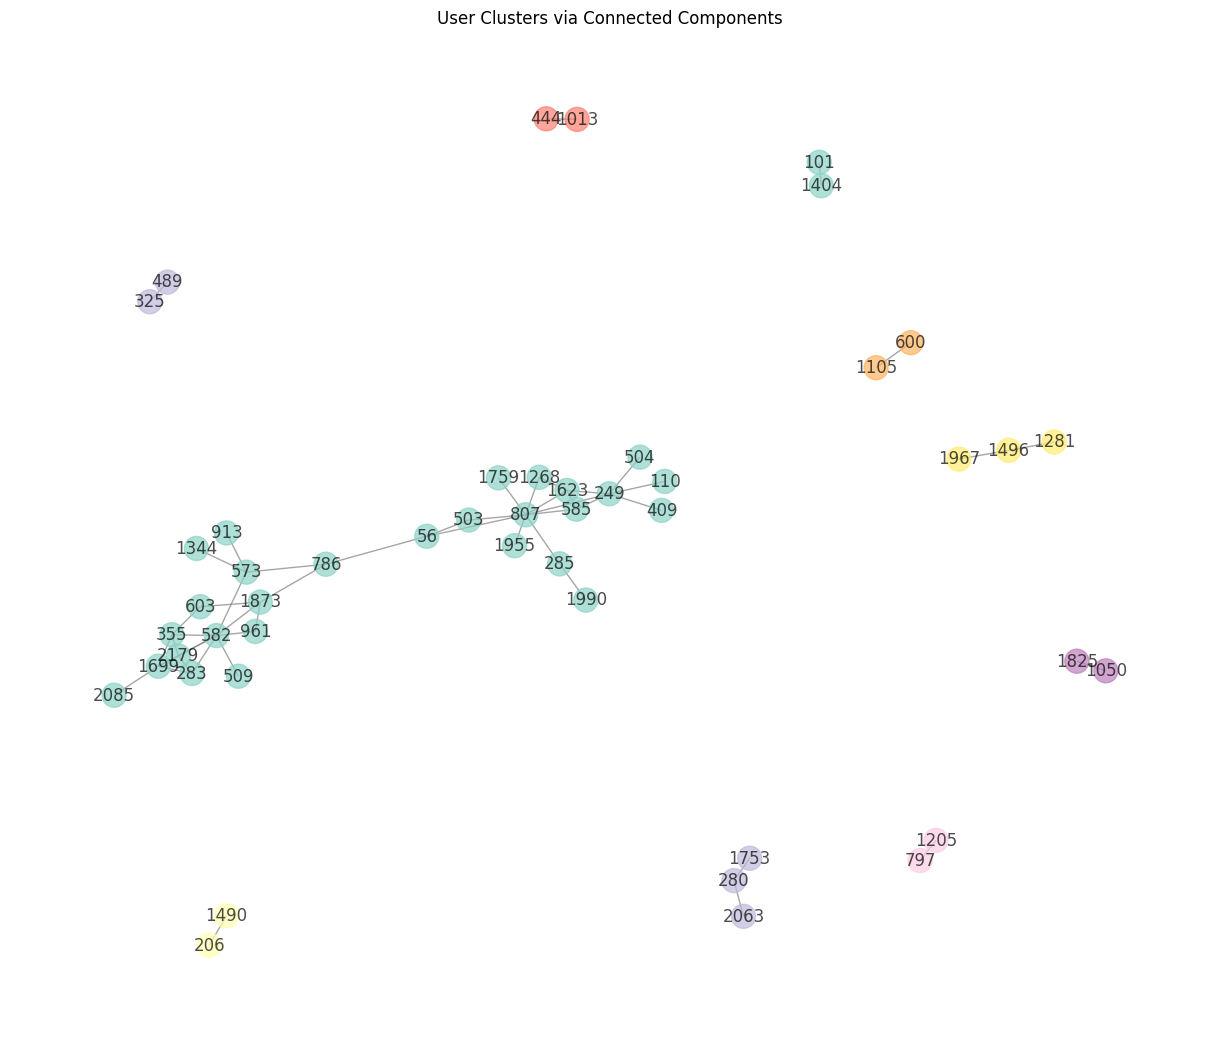

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# For demonstration purposes, you might sample the edges if the graph is very large.
# Here, we use .limit(1000) to take a subset. Adjust as needed.
sampled_edges = edges.limit(1000).select("src", "dst", "JaccardDistance")
sampled_vertices = vertices.limit(1000).select("id")

# Collect data to local Pandas DataFrames
edges_pd = sampled_edges.toPandas()
vertices_pd = sampled_vertices.toPandas()

# Also, collect cluster information to map nodes to clusters.
clusters_pd = clusters.join(vertices, clusters.id == vertices.id, "inner") \
                      .select(vertices.id, "component") \
                      .toPandas()

# Create the NetworkX graph from the edges DataFrame
G = nx.from_pandas_edgelist(edges_pd, source='src', target='dst', edge_attr='JaccardDistance')

# Create a dictionary for cluster assignments
cluster_dict = dict(zip(clusters_pd['id'], clusters_pd['component']))

# For each node in the graph, assign a color based on its cluster component.
# If a node is missing from the cluster_dict, default to 0.
node_colors = [cluster_dict.get(node, 0) for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 10))
# Using a spring layout for visualization; seed ensures reproducibility.
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    cmap=plt.cm.Set3,
    node_size=300,
    edge_color='gray',
    alpha=0.7
)
plt.title("User Clusters via Connected Components")
plt.show()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


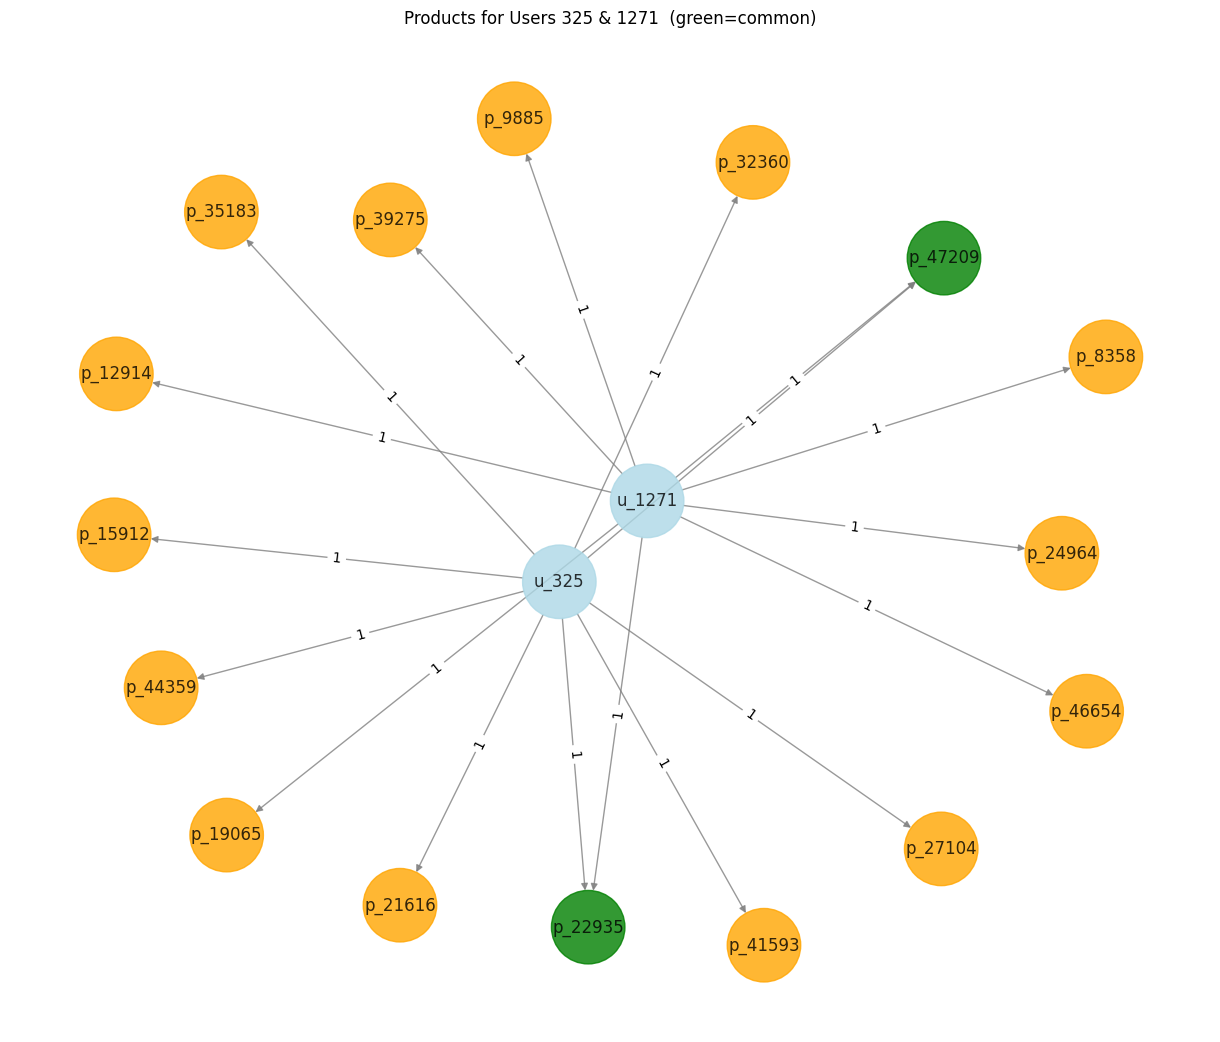

In [5]:
# 1. Imports & SparkSession (with GraphFrames)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, concat
from graphframes import GraphFrame

# 2. Load only the columns you need
tx = (
    spark.read
         .csv("official_df.csv", header=True, inferSchema=True)
         .select("user_id", "product_id", "product_name", "reordered")
)

# 3. Build vertices: users and products in one union’d DF
users_df = (
    tx.select(col("user_id").alias("id"))
      .distinct()
      .withColumn("id", concat(lit("u_"), col("id")))
      .withColumn("type", lit("user"))
      .withColumn("product_name", lit(None).cast("string"))
)
products_df = (
    tx.select(col("product_id").alias("id"), "product_name")
      .distinct()
      .withColumn("id", concat(lit("p_"), col("id")))
      .withColumn("type", lit("product"))
)
vertices = users_df.unionByName(products_df)

# 4. Build edges: user→product, carry the `reordered` flag (or weight)
edges = (
    tx.select("user_id", "product_id", "reordered")
      .distinct()
      .withColumn("src", concat(lit("u_"), col("user_id")))
      .withColumn("dst", concat(lit("p_"), col("product_id")))
      .select("src", "dst", col("reordered").alias("weight"))
)

# 5. Make the GraphFrame
g = GraphFrame(vertices, edges)

# 6. Visualization helper (NetworkX + Matplotlib)
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def visualize_user_pair_graph(gf, user1_raw, user2_raw, node_size=2800):
    # Prefix inputs
    u1, u2 = f"u_{user1_raw}", f"u_{user2_raw}"

    # Pull edges for each user
    e1 = gf.edges.filter(col("src")==u1).toPandas()
    e2 = gf.edges.filter(col("src")==u2).toPandas()

    # Product sets
    p1 = set(e1.dst)
    p2 = set(e2.dst)
    union_p = p1 | p2
    common_p = p1 & p2

    # Pull needed vertices
    verts = (
        gf.vertices
          .filter(col("id").isin([u1, u2] + list(union_p)))
          .toPandas()
    )

    # Build NetworkX graph
    G = nx.DiGraph()
    for _, r in verts.iterrows():
        G.add_node(r.id, type=r.type)
    for df in (e1, e2):
        for _, r in df.iterrows():
            if r.dst in union_p:
                G.add_edge(r.src, r.dst, weight=r.weight or 1)

    # Layout & colors
    pos = nx.spring_layout(G, seed=42)
    color_map = []
    for n, data in G.nodes(data=True):
        if data['type']=="user":
            color_map.append('lightblue')
        elif n in common_p:
            color_map.append('green')
        else:
            color_map.append('orange')

    # Draw
    plt.figure(figsize=(12,10))
    nx.draw(G, pos, with_labels=True,
            node_size=node_size,
            node_color=color_map,
            edge_color='gray', alpha=0.8)
    edge_lbl = {(u,v):d['weight'] for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_lbl)
    plt.title(f"Products for Users {user1_raw} & {user2_raw}  (green=common)")
    plt.show()

# 7. Example
visualize_user_pair_graph(g, user1_raw=325, user2_raw=1271)

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, collect_list, count, desc, row_number, rand
)
from pyspark.sql.window import Window
from pyspark.ml.feature import HashingTF, MinHashLSH

# ————————————————————————————————————————————————————————————
# 1. Load & prepare transaction data
tx = (
    spark.read
         .csv("official_df.csv", header=True, inferSchema=True)
         .select("user_id", "product_id", "reordered")
)

# Build (user, item) pairs
user_items = (
    tx
    .select(
        col("user_id").alias("user"),
        col("product_id").alias("item")
    )
    .distinct()
)

# ————————————————————————————————————————————————————————————
# 2. Compute user–user similarity via MinHashLSH
# 2a. Create item-set features
user_feats = (
    user_items
    .groupBy("user")
    .agg(collect_list("item").alias("items"))
)

hashingTF = HashingTF(
    inputCol="items", outputCol="features",
    numFeatures=10_000, binary=True
)
user_feats = hashingTF.transform(user_feats)

mh = MinHashLSH(
    inputCol="features", outputCol="hashes",
    numHashTables=3
)
mh_model = mh.fit(user_feats)
user_feats = mh_model.transform(user_feats)

# 2b. Similarity join (keep pairs with JaccardDistance ≤ maxDistance)
similarityThreshold = 0.2
maxDistance = 1.0 - similarityThreshold

raw_pairs = mh_model.approxSimilarityJoin(
    user_feats, user_feats, maxDistance, distCol="JaccardDistance"
)

neighbors = (
    raw_pairs
    .filter("datasetA.user != datasetB.user")
    .selectExpr(
        "datasetA.user  AS user",
        "datasetB.user  AS neighbor",
        "JaccardDistance"
    )
    .distinct()
)

# ————————————————————————————————————————————————————————————
# 3. Generate candidate items from neighbors
neighbor_items = (
    neighbors.alias("n")
             .join(user_items.alias("ui"),
                   col("n.neighbor") == col("ui.user"),
                   how="inner")
             .select(
                 col("n.user").alias("user"),
                 col("ui.item").alias("item")
             )
)

# ————————————————————————————————————————————————————————————
# 4. Score each candidate by # of neighbors who bought it
candidate_scores = (
    neighbor_items
    .groupBy("user", "item")
    .agg(count("*").alias("score"))
)

# ————————————————————————————————————————————————————————————
# 5. Remove items the user already has
scores_filtered = candidate_scores.join(
    user_items,
    on=["user", "item"],
    how="left_anti"
)

# ————————————————————————————————————————————————————————————
# 6. Rank & pick top-N per user
N = 10
window = Window.partitionBy("user").orderBy(desc("score"))

topN = (
    scores_filtered
    .withColumn("rank", row_number().over(window))
    .filter(col("rank") <= N)
    .orderBy("user", "rank")
)

# ————————————————————————————————————————————————————————————
# 7. (Debug) Neighbor counts & sample some users
neighbor_counts = (
    neighbors
    .groupBy("user")
    .agg(count("*").alias("num_neighbors"))
)
neighbor_counts.orderBy(desc("num_neighbors")).show(10, truncate=False)

active_users = neighbor_counts.filter(col("num_neighbors") > 0).select("user")

sample_users = (
    active_users
    .orderBy(rand(42))
    .limit(5)
)

sample_recs = (
    topN
    .join(sample_users, on="user", how="inner")
    .orderBy("user", "rank")
)

sample_recs.show(truncate=False)

+----+-------------+
|user|num_neighbors|
+----+-------------+
|807 |2            |
|249 |1            |
|283 |1            |
|355 |1            |
|1623|1            |
|1699|1            |
|2179|1            |
+----+-------------+

+----+-----+-----+----+
|user|item |score|rank|
+----+-----+-----+----+
|283 |8571 |1    |1   |
|283 |7131 |1    |2   |
|807 |27845|1    |1   |
|807 |36011|1    |2   |
|807 |43692|1    |3   |
|807 |47766|1    |4   |
|807 |41220|1    |5   |
|807 |20822|1    |6   |
|1699|32303|1    |1   |
|1699|41596|1    |2   |
|1699|32971|1    |3   |
|1699|41973|1    |4   |
+----+-----+-----+----+

